In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import portfolio_analysis_toolkit as patk

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-v0_8-darkgrid")

## Portfolio construction

We'll calculate the efficient frontier from a set of expected returns, volatilities (or variances), and correlations (or covariances). The question is how to obtain these figures for the future, but for now, we'll assume that historical returns are a reasonable estimate. We'll see how to improve it later.

Here we will get the timeseries of some stocks and see how to construct a portfolio in an efficient way.

In [6]:
tickers = ["AI.PA", "TTE.PA", "SU.PA", "OR.PA", "MC.PA"]
start_date = "2019-01-01"
end_date = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date, interval="1mo", auto_adjust=True)

ajd_close = data["Close"]

# Creating the CSV data file
ajd_close.to_csv("prices_fr_stocks_portfolio.csv")

ajd_close

[*********************100%***********************]  5 of 5 completed


Ticker,AI.PA,MC.PA,OR.PA,SU.PA,TTE.PA
Date,,,,,
2019-01-01,70.699081,251.566620,187.025208,52.986919,32.550144
2019-02-01,73.168045,271.575104,197.529236,58.398281,33.913742
2019-03-01,75.637009,294.865784,213.463318,59.695644,33.594902
2019-04-01,79.106895,313.885071,218.181244,64.407104,34.028503
2019-05-01,74.402527,307.998291,217.432419,62.338154,32.033298
...,...,...,...,...,...
2024-08-01,168.720001,658.026123,389.541260,225.647385,59.692192
2024-09-01,173.259995,671.883362,394.894257,232.032700,56.150398
2024-10-01,164.660004,595.082764,338.122986,233.015060,55.797615


This looks good, so let's add the following code to our module "portfolio_analysis_toolkit" for future use :

```python

def get_stk_returns():
    
    """
    Load and format the returns_fr_stocks_portfolio.csv
    """
    stk = pd.read_csv("returns_fr_stocks_portfolio.csv",
                      header=0, index_col=0, parse_dates=True)
    stk.index = stk.index.to_period('M')
    return stk
    
```

In [11]:
returns = patk.get_stk_returns()
returns

,AI.PA,MC.PA,OR.PA,SU.PA,TTE.PA
Date,,,,,
2019-02,0.034922,0.079535,0.056164,0.102126,0.041892
2019-03,0.033744,0.085762,0.080667,0.022216,-0.009402
2019-04,0.045876,0.064501,0.022102,0.078925,0.012907
2019-05,-0.059469,-0.018754,-0.003432,-0.032123,-0.058634
2019-06,0.128919,0.105434,0.042013,0.126554,0.056497
...,...,...,...,...,...
2024-08,-0.000355,0.032619,-0.010109,0.030738,-0.004641
2024-09,0.026908,0.021059,0.013742,0.028298,-0.059334
2024-10,-0.049636,-0.114306,-0.143763,0.004234,-0.006283


Now we have the returns of each stock for each month of the entire period.

Let's use this as an opportunity to write functions for annualized returns, volatility and sharpe ratios : 

```python

def annualize_rets(r, periods_per_year):
    
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to  a per period rate
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

```

## Expected Returns and the Covariance 

We can generate an estimate of expected returns using the `annualize_rets()` function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 2019 through 2024:

In [14]:
er = patk.annualize_rets(returns, 12)
print("Annualize returns (%):")
er.sort_values()

Annualize returns (%):


TTE.PA    0.081973
OR.PA     0.103958
AI.PA     0.144257
MC.PA     0.164739
SU.PA     0.287800
dtype: float64

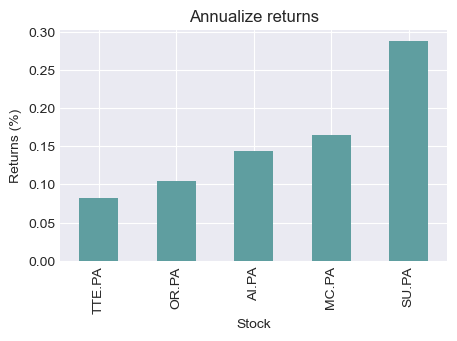

In [15]:
ax = er.sort_values().plot.bar(figsize = (5, 3), color='cadetblue')
ax.set_title('Annualize returns')
ax.set_xlabel("Stock") 
ax.set_ylabel("Returns (%)")
plt.show()

In [17]:
print("Annualize volatility (%):")
patk.annualize_vol(returns, 12)

Annualize volatility (%):


AI.PA     0.182503
MC.PA     0.236346
OR.PA     0.200533
SU.PA     0.234006
TTE.PA    0.273378
dtype: float64

Finally, let's generate the covariance matrix. Fortunately, this is easy enough to do using the `.cov` method:

In [23]:
cov = returns.cov()
cov

,AI.PA,MC.PA,OR.PA,SU.PA,TTE.PA
AI.PA,0.002776,0.001830,0.001445,0.002278,0.001296
MC.PA,0.001830,0.004655,0.002846,0.002954,0.001734
OR.PA,0.001445,0.002846,0.003351,0.002313,0.000639
SU.PA,0.002278,0.002954,0.002313,0.004563,0.000934
TTE.PA,0.001296,0.001734,0.000639,0.000934,0.006228




We'll take the expected returns vector and the covariance matrix we've constructed and start to plot the efficient frontier.

## The Efficient Frontier and running the optimazer

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating a function that plots the efficient frontier for cases of more than 2 assets : 

```python

def plot_ef(n_points, er, cov):
    
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    
    return ef.plot.line(x="Volatility", y="Returns", style='--')
    
```
    
    In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.


```python

from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
    
```

Let's use this to create the frontier for the 2-Asset :

```

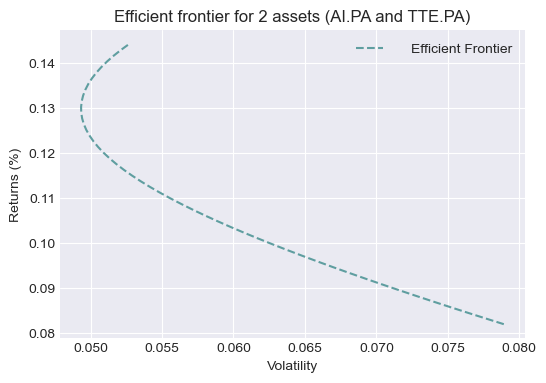

In [27]:
s = ["AI.PA", "TTE.PA"]
ax = patk.plot_ef(50, er[s], cov.loc[s, s])
ax.set_title("Efficient frontier for 2 assets (AI.PA and TTE.PA)")
plt.show()

The Efficient Frontier for the protfolio that has a target return of 0.049 is approx 0.13, so let's see if our optimizer is able to locate it.

In [30]:
weights_13 = patk.minimize_vol(0.13, er[s], cov.loc[s,s])
vol_13= patk.portfolio_vol(weights_13, cov.loc[s,s])
vol_13

0.04933681358659488

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

```python

def optimal_weights(n_points, er, cov):
    
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
    
```

Let's see what we have with all our assets :

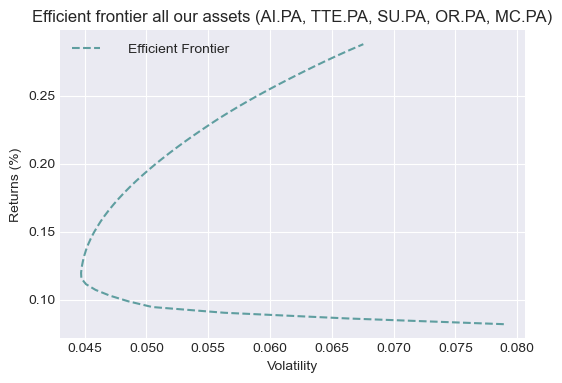

In [33]:
s = ["AI.PA", "TTE.PA", "SU.PA", "OR.PA", "MC.PA"]
ax = patk.plot_ef(50, er[s], cov.loc[s,s])
ax.set_title("Efficient frontier all our assets (AI.PA, TTE.PA, SU.PA, OR.PA, MC.PA)")
plt.show()

## Finding the Max Sharpe Ratio Portfolio in presence of non null risk-free-rate

Recall that a **risk-free asset** is an (hypothetical) asset with a risk-free rate. For example, **short-term government securities (such as US treasury bills)** are used as a risk-free asset since **they pay a fixed interest rate and have exceptionally low default risk**.

The risk-free asset has zero volatility. Furthermore, it is also uncorrelated with any other asset since, by definition, its volatility is zero. Therefore, when combined with any other asset in a portfolio, the change in return is linearly related to the change in risk as the proportions in the combination vary.

## The capital market line (CML)

When a risk-free asset is introduced, there will be a line satisfying:

1. it is tangent to the curve at the risky portfolio with the highest Sharpe ratio;
2. the tangency with the curve represents the highest sharpe ratio portfolio with no risk-free holdings and of risky assets;
3. assets held in the portfolio occurring at the tangency point;
4. points on this line represent portfolios containing positive amounts of both the risky assets and the risk-free asset.


We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. In this section, we'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangency portfolio or the Max Sharpe Ratio portfolio.

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

```python

def msr(riskfree_rate, er, cov): 
    
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0] 
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1 
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)  
    return weights.x
```

Let's guess where the point might be:

Let's put it all together by adding the CML to the `plot_ef` code.

```python

    if show_cml:
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='tomato', linestyle='--', linewidth=2, label="CML (Capital Market Line)")
        ax.plot(vol_msr, r_msr, 'x', color='firebrick', markeredgewidth=16, label="MSR Portfolio")
        
```


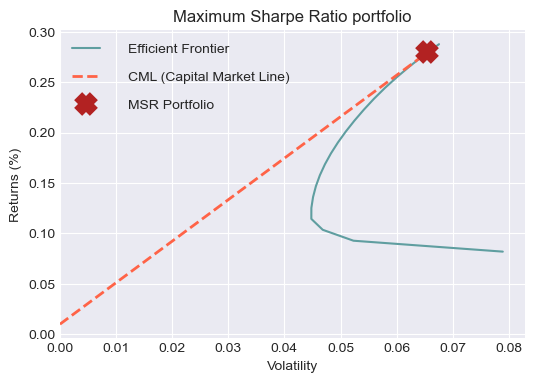

In [38]:
ax = patk.plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.01)
ax.set_xlim(left = 0.00)
ax.set_title("Maximum Sharpe Ratio portfolio")
plt.show()

## Lack of Robustness of the Markowitz procedure and the GMV portfolio

The problem of the Markowitz procedure is that we rarely know Expected Returns and Expected Covariance in advance. Our estimates almost certainly contain some estimation error, and we'll see that the procedure is highly sensitive to these errors, which tend to get exaggerated in the portfolio.

Let's look at a simple 2-asset portfolio and find the optimal weights if we had known what the returns would be : 

In [41]:
s = ["OR.PA", "TTE.PA"]
risk_free_rate = 0.01
patk.msr(risk_free_rate, np.array(er[s]), cov.loc[s,s])

array([0.748561, 0.251439])

We see that the optimal portfolio would have been 74,85% in OR.PA and 25,14% in TTE.PA.

Let's look at the returns of the two assets that dictated those weights

In [44]:
er[s]

OR.PA     0.103958
TTE.PA    0.081973
dtype: float64

Now assume that we had a really good estimator, and we were off by only a fraction of a percent in our estimate, and we had estimated a return of 11% in OR.PA and 9% in TTE.PA instead of the return of 10.39% and 8.19% : 

In [47]:
patk.msr(0.01, np.array([.11, .9]), cov.loc[s, s])

array([0.01805497, 0.98194503])

We see that even a small change in the estimate causes a major change in the weights. 

MSR Portfolio :
  Return:        28.78%
  Volatility:    6.76%
  Sharpe Ratio:  2.78


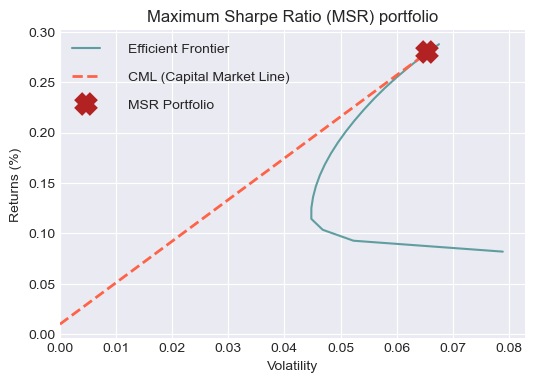

In [50]:
w_msr = patk.msr(riskfree_rate=0.1, er=er, cov=cov)
patk.portfolio_stat("MSR", w_msr, er, cov, riskfree_rate=0.1)

ax = patk.plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.01)
ax.set_xlim(left = 0.00)
ax.set_title("Maximum Sharpe Ratio (MSR) portfolio")
plt.show()

In [52]:
risk_free_rate = 0.01
optimal_weights = patk.msr(risk_free_rate, er, cov)

print("Optimal Weights:")
print("  AI.PA:  {:.2f}%".format(optimal_weights[0]*100))
print("  TTE.PA: {:.2f}%".format(optimal_weights[1]*100))
print("  SU.PA:  {:.2f}%".format(optimal_weights[2]*100))
print("  OR.PA:  {:.2f}%".format(optimal_weights[3]*100))
print("  MC.PA:  {:.2f}%".format(optimal_weights[4]*100))

Optimal Weights:
  AI.PA:  0.00%
  TTE.PA: 0.00%
  SU.PA:  0.00%
  OR.PA:  96.03%
  MC.PA:  3.97%


## Avoiding estimating returns

One way to avoid these estimations is to skip the entire process and just rely on naive diversification, which means hold all stocks with equal weight. We can add the EW portfolio to the plot by enhancing the plot_ef function as follows:

```python

    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], 'x', color='olive', markeredgewidth=16, label="EW Portfolio")

```

EW Portfolio :
  Return:        15.65%
  Volatility:    4.82%
  Sharpe Ratio:  1.17


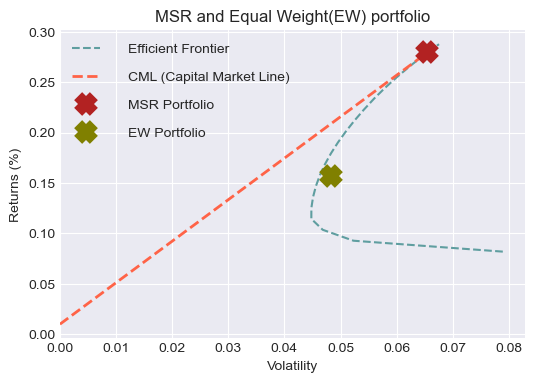

In [55]:
n = er.shape[0]
w_ew = np.repeat(1/n, n)
patk.portfolio_stat("EW", w_ew, er, cov)

ax = patk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.01, show_ew=True)
ax.set_xlim(left = 0.00)
ax.set_title("MSR and Equal Weight(EW) portfolio")
plt.show()

In [57]:
w_ew = patk.ew(er)
print("EW Portfolio:")
print("  AI.PA:  {:.2f}%".format(w_ew[0] * 100))
print("  TTE.PA: {:.2f}%".format(w_ew[1] * 100))
print("  SU.PA:  {:.2f}%".format(w_ew[2] * 100))
print("  OR.PA:  {:.2f}%".format(w_ew[3] * 100))
print("  MC.PA:  {:.2f}%".format(w_ew[4] * 100))

EW Portfolio:
  AI.PA:  20.00%
  TTE.PA: 20.00%
  SU.PA:  20.00%
  OR.PA:  20.00%
  MC.PA:  20.00%


We also can find these results in another way : 

In [60]:
ew = np.repeat(0.2, 5)

patk.portfolio_return(ew, er)

0.15654557315197024

In [62]:
patk.portfolio_vol(ew, cov)

0.0482132761654361

In [64]:
stk = ["AI.PA", "TTE.PA", "SU.PA", "OR.PA", "MC.PA"]
print("The weight of each stock in the equally weighted portfolio is : ",  1 / len(stk))

The weight of each stock in the equally weighted portfolio is :  0.2


In [66]:
ew

array([0.2, 0.2, 0.2, 0.2, 0.2])

The EW portfolio is a remarkably good portfolio to hold, but as you can see, the EW portfolio is far inside the efficient frontier, but it requires no estimation whatsoever.

However, there is another point on the efficient frontier that is very interesting. This is the nose of the hull, which is the portfolio of lowest volatility across all possible portfolios. This is called the Global Minimum Volatility or GMV portfolio.

But how do we find the weights of the GMV portfolio ?

The interesting thing about it is that if you assume that all returns are the same, the optimizer cannot improve the sharpe ratio through raising returns, and so it must do so my lowering volatility. This means that if we just skip any returns estimation and assume all returns have the same return, we'd get the weights of the GMV portfolio.

```python

def gmv(cov):
    
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)
    
```
and we can add that to the plot as follows:

```python

    if show_gmv:
        w_gmv = gmv(cov) 
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], 'x', color='teal', markeredgewidth=16, label="GMV Portfolio")
```

GMV Portfolio :
  Return:        11.74%
  Volatility:    4.47%
  Sharpe Ratio:  0.39


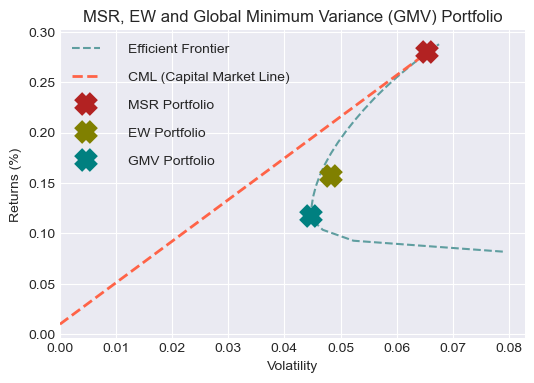

In [69]:
w_msr = patk.gmv(cov)
patk.portfolio_stat("GMV", w_msr, er, cov, )


ax = patk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.01, show_ew=True, show_gmv=True)
ax.set_xlim(left=0.00)
ax.set_title("MSR, EW and Global Minimum Variance (GMV) Portfolio")
plt.show()

In [71]:
w_gmv = patk.gmv(cov)
print("GMV Portfolio:")
print("  AI.PA:  {:.2f}%".format(w_gmv[0] * 100))
print("  TTE.PA: {:.2f}%".format(w_gmv[1] * 100))
print("  SU.PA:  {:.2f}%".format(w_gmv[2] * 100))
print("  OR.PA:  {:.2f}%".format(w_gmv[3] * 100))
print("  MC.PA:  {:.2f}%".format(w_gmv[4] * 100))


GMV Portfolio:
  AI.PA:  43.70%
  TTE.PA: 0.00%
  SU.PA:  37.12%
  OR.PA:  0.00%
  MC.PA:  19.18%


## In summary : 

The red dot (MSR portfolio) is where we would like to be. A high return and a high Sharpe ratio. But unless we have good estimates of expected returns, it is very difficult to achieve this. Because if we slightly change the expected return, the dot wobbles in all directions.

No expected return is required for the khaki dot (EW portfolio), which still has a good return and a satisfactory Sharpe ratio. Nor for the turquoise dot (GMV portfolio), which does not have a good Sharpe ratio but is at the lowest volatility possible.

Even if the GMV portfolio requires an estimate of the covariance matrix, with the technology, it is possible to reasonably consider the covariance matrix.